In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "2:3"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 151706 images
Dataset type val label type: species


Loaded 37931 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 55824 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 41868 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

2:3 oo98862g


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-oo98862g:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                           | 0/1186 [00:00<?, ?it/s]

  0%|                                                                                                                                                   | 1/1186 [00:01<21:51,  1.11s/it]

  1%|▋                                                                                                                                                  | 6/1186 [00:01<03:04,  6.41it/s]

  1%|█▎                                                                                                                                                | 11/1186 [00:01<01:36, 12.22it/s]

  1%|█▉                                                                                                                                                | 16/1186 [00:01<01:05, 17.96it/s]

  2%|██▌                                                                                                                                               | 21/1186 [00:01<00:50, 23.29it/s]

  2%|███▏                                                                                                                                              | 26/1186 [00:01<00:41, 27.95it/s]

  3%|███▊                                                                                                                                              | 31/1186 [00:01<00:36, 31.91it/s]

  3%|████▍                                                                                                                                             | 36/1186 [00:01<00:32, 35.09it/s]

  3%|█████                                                                                                                                             | 41/1186 [00:02<00:30, 37.58it/s]

  4%|█████▋                                                                                                                                            | 46/1186 [00:02<00:28, 39.48it/s]

  4%|██████▎                                                                                                                                           | 51/1186 [00:02<00:27, 40.82it/s]

  5%|██████▉                                                                                                                                           | 56/1186 [00:02<00:27, 41.83it/s]

  5%|███████▌                                                                                                                                          | 61/1186 [00:02<00:26, 42.61it/s]

  6%|████████                                                                                                                                          | 66/1186 [00:02<00:25, 43.09it/s]

  6%|████████▋                                                                                                                                         | 71/1186 [00:02<00:25, 43.22it/s]

  6%|█████████▎                                                                                                                                        | 76/1186 [00:02<00:25, 43.54it/s]

  7%|█████████▉                                                                                                                                        | 81/1186 [00:02<00:25, 43.81it/s]

  7%|██████████▌                                                                                                                                       | 86/1186 [00:03<00:25, 43.95it/s]

  8%|███████████▏                                                                                                                                      | 91/1186 [00:03<00:24, 44.07it/s]

  8%|███████████▊                                                                                                                                      | 96/1186 [00:03<00:24, 44.19it/s]

  9%|████████████▎                                                                                                                                    | 101/1186 [00:03<00:24, 44.23it/s]

  9%|████████████▉                                                                                                                                    | 106/1186 [00:03<00:24, 44.23it/s]

  9%|█████████████▌                                                                                                                                   | 111/1186 [00:03<00:24, 44.27it/s]

 10%|██████████████▏                                                                                                                                  | 116/1186 [00:03<00:24, 44.34it/s]

 10%|██████████████▊                                                                                                                                  | 121/1186 [00:03<00:24, 44.32it/s]

 11%|███████████████▍                                                                                                                                 | 126/1186 [00:03<00:23, 44.31it/s]

 11%|████████████████                                                                                                                                 | 131/1186 [00:04<00:23, 44.36it/s]

 11%|████████████████▋                                                                                                                                | 136/1186 [00:04<00:23, 44.31it/s]

 12%|█████████████████▏                                                                                                                               | 141/1186 [00:04<00:23, 44.29it/s]

 12%|█████████████████▊                                                                                                                               | 146/1186 [00:04<00:23, 44.31it/s]

 13%|██████████████████▍                                                                                                                              | 151/1186 [00:04<00:23, 44.37it/s]

 13%|███████████████████                                                                                                                              | 156/1186 [00:04<00:23, 44.34it/s]

 14%|███████████████████▋                                                                                                                             | 161/1186 [00:04<00:23, 44.33it/s]

 14%|████████████████████▎                                                                                                                            | 166/1186 [00:04<00:22, 44.37it/s]

 14%|████████████████████▉                                                                                                                            | 171/1186 [00:04<00:22, 44.34it/s]

 15%|█████████████████████▌                                                                                                                           | 176/1186 [00:05<00:22, 44.30it/s]

 15%|██████████████████████▏                                                                                                                          | 181/1186 [00:05<00:22, 44.30it/s]

 16%|██████████████████████▋                                                                                                                          | 186/1186 [00:05<00:22, 44.35it/s]

 16%|███████████████████████▎                                                                                                                         | 191/1186 [00:05<00:22, 44.34it/s]

 17%|███████████████████████▉                                                                                                                         | 196/1186 [00:05<00:22, 44.32it/s]

 17%|████████████████████████▌                                                                                                                        | 201/1186 [00:05<00:22, 44.35it/s]

 17%|█████████████████████████▏                                                                                                                       | 206/1186 [00:05<00:22, 44.33it/s]

 18%|█████████████████████████▊                                                                                                                       | 211/1186 [00:05<00:21, 44.34it/s]

 18%|██████████████████████████▍                                                                                                                      | 216/1186 [00:05<00:21, 44.32it/s]

 19%|███████████████████████████                                                                                                                      | 221/1186 [00:06<00:21, 44.36it/s]

 19%|███████████████████████████▋                                                                                                                     | 226/1186 [00:06<00:21, 44.33it/s]

 19%|████████████████████████████▏                                                                                                                    | 231/1186 [00:06<00:21, 44.32it/s]

 20%|████████████████████████████▊                                                                                                                    | 236/1186 [00:06<00:21, 44.36it/s]

 20%|█████████████████████████████▍                                                                                                                   | 241/1186 [00:06<00:21, 44.36it/s]

 21%|██████████████████████████████                                                                                                                   | 246/1186 [00:06<00:21, 44.29it/s]

 21%|██████████████████████████████▋                                                                                                                  | 251/1186 [00:06<00:21, 44.24it/s]

 22%|███████████████████████████████▎                                                                                                                 | 256/1186 [00:06<00:21, 44.25it/s]

 22%|███████████████████████████████▉                                                                                                                 | 261/1186 [00:06<00:20, 44.25it/s]

 22%|████████████████████████████████▌                                                                                                                | 266/1186 [00:07<00:20, 44.31it/s]

 23%|█████████████████████████████████▏                                                                                                               | 271/1186 [00:07<00:20, 44.30it/s]

 23%|█████████████████████████████████▋                                                                                                               | 276/1186 [00:07<00:20, 44.31it/s]

 24%|██████████████████████████████████▎                                                                                                              | 281/1186 [00:07<00:20, 44.31it/s]

 24%|██████████████████████████████████▉                                                                                                              | 286/1186 [00:07<00:20, 44.38it/s]

 25%|███████████████████████████████████▌                                                                                                             | 291/1186 [00:07<00:20, 44.34it/s]

 25%|████████████████████████████████████▏                                                                                                            | 296/1186 [00:07<00:20, 44.31it/s]

 25%|████████████████████████████████████▊                                                                                                            | 301/1186 [00:07<00:19, 44.38it/s]

 26%|█████████████████████████████████████▍                                                                                                           | 306/1186 [00:07<00:19, 44.36it/s]

 26%|██████████████████████████████████████                                                                                                           | 311/1186 [00:08<00:19, 44.33it/s]

 27%|██████████████████████████████████████▋                                                                                                          | 316/1186 [00:08<00:19, 44.32it/s]

 27%|███████████████████████████████████████▏                                                                                                         | 321/1186 [00:08<00:19, 44.36it/s]

 27%|███████████████████████████████████████▊                                                                                                         | 326/1186 [00:08<00:19, 44.35it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 331/1186 [00:08<00:19, 44.30it/s]

 28%|█████████████████████████████████████████                                                                                                        | 336/1186 [00:08<00:19, 44.30it/s]

 29%|█████████████████████████████████████████▋                                                                                                       | 341/1186 [00:08<00:19, 44.34it/s]

 29%|██████████████████████████████████████████▎                                                                                                      | 346/1186 [00:08<00:18, 44.34it/s]

 30%|██████████████████████████████████████████▉                                                                                                      | 351/1186 [00:09<00:18, 44.35it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 356/1186 [00:09<00:18, 44.39it/s]

 30%|████████████████████████████████████████████▏                                                                                                    | 361/1186 [00:09<00:18, 44.38it/s]

 31%|████████████████████████████████████████████▋                                                                                                    | 366/1186 [00:09<00:18, 44.34it/s]

 31%|█████████████████████████████████████████████▎                                                                                                   | 371/1186 [00:09<00:18, 44.31it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 376/1186 [00:09<00:18, 44.38it/s]

 32%|██████████████████████████████████████████████▌                                                                                                  | 381/1186 [00:09<00:18, 44.35it/s]

 33%|███████████████████████████████████████████████▏                                                                                                 | 386/1186 [00:09<00:18, 44.32it/s]

 33%|███████████████████████████████████████████████▊                                                                                                 | 391/1186 [00:09<00:17, 44.30it/s]

 33%|████████████████████████████████████████████████▍                                                                                                | 396/1186 [00:10<00:17, 44.35it/s]

 34%|█████████████████████████████████████████████████                                                                                                | 401/1186 [00:10<00:17, 44.33it/s]

 34%|█████████████████████████████████████████████████▋                                                                                               | 406/1186 [00:10<00:17, 44.33it/s]

 35%|██████████████████████████████████████████████████▏                                                                                              | 411/1186 [00:10<00:17, 44.35it/s]

 35%|██████████████████████████████████████████████████▊                                                                                              | 416/1186 [00:10<00:17, 44.39it/s]

 35%|███████████████████████████████████████████████████▍                                                                                             | 421/1186 [00:10<00:17, 44.32it/s]

 36%|████████████████████████████████████████████████████                                                                                             | 426/1186 [00:10<00:17, 44.30it/s]

 36%|████████████████████████████████████████████████████▋                                                                                            | 431/1186 [00:10<00:17, 44.36it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                           | 436/1186 [00:10<00:16, 44.34it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                           | 441/1186 [00:11<00:16, 44.31it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                          | 446/1186 [00:11<00:16, 44.29it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                         | 451/1186 [00:11<00:16, 44.32it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                         | 456/1186 [00:11<00:16, 44.21it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                        | 461/1186 [00:11<00:16, 44.31it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                        | 466/1186 [00:11<00:16, 44.31it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                       | 471/1186 [00:11<00:16, 44.36it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                      | 476/1186 [00:11<00:16, 44.32it/s]

 41%|██████████████████████████████████████████████████████████▊                                                                                      | 481/1186 [00:11<00:15, 44.24it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                     | 486/1186 [00:12<00:15, 44.25it/s]

 41%|████████████████████████████████████████████████████████████                                                                                     | 491/1186 [00:12<00:15, 44.33it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                    | 496/1186 [00:12<00:15, 44.32it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                   | 501/1186 [00:12<00:15, 44.32it/s]

 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 506/1186 [00:12<00:15, 44.36it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                  | 511/1186 [00:12<00:15, 44.24it/s]

 44%|███████████████████████████████████████████████████████████████                                                                                  | 516/1186 [00:12<00:15, 44.29it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                 | 521/1186 [00:12<00:15, 44.28it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                | 526/1186 [00:12<00:14, 44.29it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                                | 531/1186 [00:13<00:14, 44.37it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                               | 536/1186 [00:13<00:14, 44.34it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                              | 541/1186 [00:13<00:14, 44.30it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                              | 546/1186 [00:13<00:14, 44.28it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                             | 551/1186 [00:13<00:14, 44.34it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                             | 556/1186 [00:13<00:14, 44.31it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                            | 561/1186 [00:13<00:14, 44.31it/s]

 48%|█████████████████████████████████████████████████████████████████████▏                                                                           | 566/1186 [00:13<00:13, 44.39it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                           | 571/1186 [00:13<00:13, 44.34it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                          | 576/1186 [00:14<00:13, 44.22it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                          | 581/1186 [00:14<00:13, 44.29it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                         | 586/1186 [00:14<00:13, 44.29it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                        | 591/1186 [00:14<00:13, 44.33it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                        | 596/1186 [00:14<00:13, 44.32it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 601/1186 [00:14<00:13, 44.31it/s]

 51%|██████████████████████████████████████████████████████████████████████████                                                                       | 606/1186 [00:14<00:13, 44.38it/s]

 52%|██████████████████████████████████████████████████████████████████████████▋                                                                      | 611/1186 [00:14<00:12, 44.32it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 616/1186 [00:14<00:12, 44.30it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                     | 621/1186 [00:15<00:12, 44.29it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                    | 626/1186 [00:15<00:12, 44.34it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                   | 631/1186 [00:15<00:12, 44.32it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                   | 636/1186 [00:15<00:12, 44.33it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 641/1186 [00:15<00:12, 44.37it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                  | 646/1186 [00:15<00:12, 44.27it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                 | 651/1186 [00:15<00:12, 44.28it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                | 656/1186 [00:15<00:11, 44.35it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                                | 661/1186 [00:16<00:11, 44.39it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                               | 666/1186 [00:16<00:11, 44.35it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                               | 671/1186 [00:16<00:11, 44.33it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                              | 676/1186 [00:16<00:11, 44.31it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                             | 681/1186 [00:16<00:11, 44.26it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                             | 686/1186 [00:16<00:11, 44.24it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                            | 691/1186 [00:16<00:11, 44.24it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 696/1186 [00:16<00:11, 44.31it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▋                                                           | 701/1186 [00:16<00:10, 44.29it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                          | 706/1186 [00:17<00:10, 44.28it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                          | 711/1186 [00:17<00:10, 44.29it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                         | 716/1186 [00:17<00:10, 44.33it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 721/1186 [00:17<00:10, 44.30it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 726/1186 [00:17<00:10, 44.30it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 731/1186 [00:17<00:10, 44.25it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 736/1186 [00:17<00:10, 44.32it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 741/1186 [00:17<00:10, 44.39it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 746/1186 [00:17<00:09, 44.37it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 751/1186 [00:18<00:09, 44.34it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 756/1186 [00:18<00:09, 44.32it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████                                                    | 761/1186 [00:18<00:09, 44.36it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 766/1186 [00:18<00:09, 44.32it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 771/1186 [00:18<00:09, 44.31it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 776/1186 [00:18<00:09, 44.37it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 781/1186 [00:18<00:09, 44.33it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 786/1186 [00:18<00:09, 44.32it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 791/1186 [00:18<00:08, 44.30it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 796/1186 [00:19<00:08, 44.34it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 801/1186 [00:19<00:08, 44.30it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 806/1186 [00:19<00:08, 44.28it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 811/1186 [00:19<00:08, 44.34it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 816/1186 [00:19<00:08, 44.34it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 821/1186 [00:19<00:08, 44.11it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 826/1186 [00:19<00:08, 43.92it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 831/1186 [00:19<00:08, 43.79it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 836/1186 [00:19<00:08, 43.72it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 841/1186 [00:20<00:07, 43.66it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 846/1186 [00:20<00:07, 43.62it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 851/1186 [00:20<00:07, 43.59it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 856/1186 [00:20<00:07, 43.58it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 861/1186 [00:20<00:07, 43.57it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 866/1186 [00:20<00:07, 43.54it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 871/1186 [00:20<00:07, 43.54it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 876/1186 [00:20<00:07, 43.54it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 881/1186 [00:20<00:07, 43.55it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 886/1186 [00:21<00:06, 43.54it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 891/1186 [00:21<00:06, 43.54it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 896/1186 [00:21<00:06, 43.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 901/1186 [00:21<00:06, 43.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 906/1186 [00:21<00:06, 43.52it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 911/1186 [00:21<00:06, 43.52it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 916/1186 [00:21<00:06, 43.52it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 921/1186 [00:21<00:06, 43.47it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 926/1186 [00:22<00:05, 43.49it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 931/1186 [00:22<00:05, 43.50it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 936/1186 [00:22<00:05, 43.50it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 941/1186 [00:22<00:05, 43.52it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 946/1186 [00:22<00:05, 43.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 951/1186 [00:22<00:05, 43.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 956/1186 [00:22<00:05, 43.52it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 961/1186 [00:22<00:05, 43.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 966/1186 [00:22<00:05, 43.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 971/1186 [00:23<00:04, 43.52it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 976/1186 [00:23<00:04, 43.52it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 981/1186 [00:23<00:04, 43.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 986/1186 [00:23<00:04, 43.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 991/1186 [00:23<00:04, 43.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 996/1186 [00:23<00:04, 43.55it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1001/1186 [00:23<00:04, 43.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1006/1186 [00:23<00:04, 43.55it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1011/1186 [00:23<00:04, 43.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1016/1186 [00:24<00:03, 43.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1021/1186 [00:24<00:03, 43.55it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1026/1186 [00:24<00:03, 43.57it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1031/1186 [00:24<00:03, 43.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1036/1186 [00:24<00:03, 43.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1041/1186 [00:24<00:03, 43.46it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1046/1186 [00:24<00:03, 43.48it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1051/1186 [00:24<00:03, 43.48it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1056/1186 [00:25<00:02, 43.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1061/1186 [00:25<00:02, 43.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1066/1186 [00:25<00:02, 43.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1071/1186 [00:25<00:02, 43.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1076/1186 [00:25<00:02, 43.53it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1081/1186 [00:25<00:02, 43.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1086/1186 [00:25<00:02, 43.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1091/1186 [00:25<00:02, 43.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1096/1186 [00:25<00:02, 43.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1101/1186 [00:26<00:01, 43.55it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1106/1186 [00:26<00:01, 43.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1111/1186 [00:26<00:01, 43.55it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1116/1186 [00:26<00:01, 43.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1121/1186 [00:26<00:01, 43.55it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1126/1186 [00:26<00:01, 43.55it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1131/1186 [00:26<00:01, 43.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1136/1186 [00:26<00:01, 43.58it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1141/1186 [00:26<00:01, 43.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1146/1186 [00:27<00:00, 43.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1151/1186 [00:27<00:00, 43.56it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1156/1186 [00:27<00:00, 43.56it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1161/1186 [00:27<00:00, 43.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1166/1186 [00:27<00:00, 43.55it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1171/1186 [00:27<00:00, 43.49it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1176/1186 [00:27<00:00, 43.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1181/1186 [00:27<00:00, 42.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:28<00:00, 41.22it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1186/1186 [00:28<00:00, 42.28it/s]

train - OK


  0%|                                                                                                                                                            | 0/297 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/297 [00:00<01:10,  4.22it/s]

  2%|██▉                                                                                                                                                 | 6/297 [00:00<00:14, 20.17it/s]

  4%|█████▍                                                                                                                                             | 11/297 [00:00<00:09, 28.66it/s]

  5%|███████▉                                                                                                                                           | 16/297 [00:00<00:08, 33.69it/s]

  7%|██████████▍                                                                                                                                        | 21/297 [00:00<00:07, 36.82it/s]

  9%|████████████▊                                                                                                                                      | 26/297 [00:00<00:06, 38.93it/s]

 10%|███████████████▎                                                                                                                                   | 31/297 [00:00<00:06, 40.31it/s]

 12%|█████████████████▊                                                                                                                                 | 36/297 [00:01<00:06, 41.19it/s]

 14%|████████████████████▎                                                                                                                              | 41/297 [00:01<00:06, 41.80it/s]

 15%|██████████████████████▊                                                                                                                            | 46/297 [00:01<00:05, 42.22it/s]

 17%|█████████████████████████▏                                                                                                                         | 51/297 [00:01<00:05, 42.52it/s]

 19%|███████████████████████████▋                                                                                                                       | 56/297 [00:01<00:05, 42.74it/s]

 21%|██████████████████████████████▏                                                                                                                    | 61/297 [00:01<00:05, 42.90it/s]

 22%|████████████████████████████████▋                                                                                                                  | 66/297 [00:01<00:05, 42.98it/s]

 24%|███████████████████████████████████▏                                                                                                               | 71/297 [00:01<00:05, 43.08it/s]

 26%|█████████████████████████████████████▌                                                                                                             | 76/297 [00:01<00:05, 43.13it/s]

 27%|████████████████████████████████████████                                                                                                           | 81/297 [00:02<00:05, 43.17it/s]

 29%|██████████████████████████████████████████▌                                                                                                        | 86/297 [00:02<00:04, 43.17it/s]

 31%|█████████████████████████████████████████████                                                                                                      | 91/297 [00:02<00:04, 43.19it/s]

 32%|███████████████████████████████████████████████▌                                                                                                   | 96/297 [00:02<00:04, 43.21it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                | 101/297 [00:02<00:04, 43.23it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 106/297 [00:02<00:04, 43.23it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                           | 111/297 [00:02<00:04, 43.22it/s]

 39%|█████████████████████████████████████████████████████████                                                                                         | 116/297 [00:02<00:04, 43.25it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                      | 121/297 [00:03<00:04, 43.21it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                    | 126/297 [00:03<00:03, 43.22it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                 | 131/297 [00:03<00:03, 43.25it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 136/297 [00:03<00:03, 43.24it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                            | 141/297 [00:03<00:03, 43.23it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 146/297 [00:03<00:03, 43.23it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                       | 151/297 [00:03<00:03, 43.24it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 156/297 [00:03<00:03, 43.19it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 161/297 [00:03<00:03, 43.21it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                                | 166/297 [00:04<00:03, 43.21it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                              | 171/297 [00:04<00:02, 43.22it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 176/297 [00:04<00:02, 43.18it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 181/297 [00:04<00:02, 43.19it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 186/297 [00:04<00:02, 43.20it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 191/297 [00:04<00:02, 43.22it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 196/297 [00:04<00:02, 43.17it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 201/297 [00:04<00:02, 43.18it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 206/297 [00:04<00:02, 43.21it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 211/297 [00:05<00:01, 43.22it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 216/297 [00:05<00:01, 43.22it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 221/297 [00:05<00:01, 43.17it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 226/297 [00:05<00:01, 43.18it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 231/297 [00:05<00:01, 43.21it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 236/297 [00:05<00:01, 43.23it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 241/297 [00:05<00:01, 43.26it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 246/297 [00:05<00:01, 43.25it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 251/297 [00:06<00:01, 43.17it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 256/297 [00:06<00:00, 43.20it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 261/297 [00:06<00:00, 43.23it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 266/297 [00:06<00:00, 43.23it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 271/297 [00:06<00:00, 43.23it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 276/297 [00:06<00:00, 43.24it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 281/297 [00:06<00:00, 43.19it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 286/297 [00:06<00:00, 43.24it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 291/297 [00:06<00:00, 43.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 296/297 [00:07<00:00, 43.12it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 297/297 [00:07<00:00, 41.35it/s]

val - OK


  0%|                                                                                                                                                            | 0/437 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                   | 1/437 [00:00<02:02,  3.55it/s]

  1%|██                                                                                                                                                  | 6/437 [00:00<00:23, 18.13it/s]

  3%|███▋                                                                                                                                               | 11/437 [00:00<00:15, 26.74it/s]

  4%|█████▍                                                                                                                                             | 16/437 [00:00<00:13, 32.16it/s]

  5%|███████                                                                                                                                            | 21/437 [00:00<00:11, 35.60it/s]

  6%|████████▋                                                                                                                                          | 26/437 [00:00<00:10, 37.97it/s]

  7%|██████████▍                                                                                                                                        | 31/437 [00:00<00:10, 39.58it/s]

  8%|████████████                                                                                                                                       | 36/437 [00:01<00:09, 40.69it/s]

  9%|█████████████▊                                                                                                                                     | 41/437 [00:01<00:09, 41.46it/s]

 11%|███████████████▍                                                                                                                                   | 46/437 [00:01<00:09, 41.98it/s]

 12%|█████████████████▏                                                                                                                                 | 51/437 [00:01<00:09, 42.35it/s]

 13%|██████████████████▊                                                                                                                                | 56/437 [00:01<00:08, 42.60it/s]

 14%|████████████████████▌                                                                                                                              | 61/437 [00:01<00:08, 42.84it/s]

 15%|██████████████████████▏                                                                                                                            | 66/437 [00:01<00:08, 43.00it/s]

 16%|███████████████████████▉                                                                                                                           | 71/437 [00:01<00:08, 43.07it/s]

 17%|█████████████████████████▌                                                                                                                         | 76/437 [00:02<00:08, 43.10it/s]

 19%|███████████████████████████▏                                                                                                                       | 81/437 [00:02<00:08, 43.14it/s]

 20%|████████████████████████████▉                                                                                                                      | 86/437 [00:02<00:08, 43.17it/s]

 21%|██████████████████████████████▌                                                                                                                    | 91/437 [00:02<00:08, 43.18it/s]

 22%|████████████████████████████████▎                                                                                                                  | 96/437 [00:02<00:07, 43.17it/s]

 23%|█████████████████████████████████▋                                                                                                                | 101/437 [00:02<00:07, 43.18it/s]

 24%|███████████████████████████████████▍                                                                                                              | 106/437 [00:02<00:07, 43.17it/s]

 25%|█████████████████████████████████████                                                                                                             | 111/437 [00:02<00:07, 43.18it/s]

 27%|██████████████████████████████████████▊                                                                                                           | 116/437 [00:02<00:07, 43.19it/s]

 28%|████████████████████████████████████████▍                                                                                                         | 121/437 [00:03<00:07, 43.17it/s]

 29%|██████████████████████████████████████████                                                                                                        | 126/437 [00:03<00:07, 43.19it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 131/437 [00:03<00:07, 43.20it/s]

 31%|█████████████████████████████████████████████▍                                                                                                    | 136/437 [00:03<00:06, 43.21it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 141/437 [00:03<00:06, 43.17it/s]

 33%|████████████████████████████████████████████████▊                                                                                                 | 146/437 [00:03<00:06, 43.17it/s]

 35%|██████████████████████████████████████████████████▍                                                                                               | 151/437 [00:03<00:06, 43.17it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 156/437 [00:03<00:06, 43.12it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                            | 161/437 [00:03<00:06, 43.15it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                          | 166/437 [00:04<00:06, 43.15it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 171/437 [00:04<00:06, 43.18it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                       | 176/437 [00:04<00:06, 43.13it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                     | 181/437 [00:04<00:05, 43.16it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                   | 186/437 [00:04<00:05, 43.16it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                  | 191/437 [00:04<00:05, 43.18it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                                | 196/437 [00:04<00:05, 43.14it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 201/437 [00:04<00:05, 43.17it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                             | 206/437 [00:05<00:05, 43.18it/s]

 48%|██████████████████████████████████████████████████████████████████████▍                                                                           | 211/437 [00:05<00:05, 43.15it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                         | 216/437 [00:05<00:05, 43.13it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                        | 221/437 [00:05<00:05, 43.10it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                      | 226/437 [00:05<00:04, 43.12it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                    | 231/437 [00:05<00:04, 43.15it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 236/437 [00:05<00:04, 43.18it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 241/437 [00:05<00:04, 43.20it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                               | 246/437 [00:05<00:04, 43.22it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                              | 251/437 [00:06<00:04, 43.14it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                            | 256/437 [00:06<00:04, 43.17it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 261/437 [00:06<00:04, 43.18it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 266/437 [00:06<00:03, 43.19it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 271/437 [00:06<00:03, 43.20it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 276/437 [00:06<00:03, 43.20it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 281/437 [00:06<00:03, 43.14it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 286/437 [00:06<00:03, 43.17it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 291/437 [00:07<00:03, 43.18it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 296/437 [00:07<00:03, 43.19it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 301/437 [00:07<00:03, 43.19it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 306/437 [00:07<00:03, 43.19it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 311/437 [00:07<00:02, 43.20it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 316/437 [00:07<00:02, 43.21it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 321/437 [00:07<00:02, 43.22it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 326/437 [00:07<00:02, 43.23it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 331/437 [00:07<00:02, 43.23it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 336/437 [00:08<00:02, 43.21it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 341/437 [00:08<00:02, 43.21it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 346/437 [00:08<00:02, 43.23it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 351/437 [00:08<00:01, 43.20it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 356/437 [00:08<00:01, 43.19it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 361/437 [00:08<00:01, 43.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 366/437 [00:08<00:01, 43.18it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 371/437 [00:08<00:01, 43.19it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 376/437 [00:08<00:01, 43.19it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 381/437 [00:09<00:01, 43.20it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 386/437 [00:09<00:01, 43.23it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 391/437 [00:09<00:01, 43.23it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 396/437 [00:09<00:00, 43.22it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 401/437 [00:09<00:00, 43.21it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 406/437 [00:09<00:00, 43.17it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 411/437 [00:09<00:00, 43.17it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 416/437 [00:09<00:00, 43.19it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 421/437 [00:10<00:00, 43.19it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 426/437 [00:10<00:00, 43.20it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 431/437 [00:10<00:00, 43.13it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 436/437 [00:10<00:00, 43.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 437/437 [00:10<00:00, 41.64it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/328 [00:00<?, ?it/s]

  0%|▍                                                                                                                                                   | 1/328 [00:00<01:49,  2.99it/s]

  2%|██▋                                                                                                                                                 | 6/328 [00:00<00:19, 16.22it/s]

  3%|████▉                                                                                                                                              | 11/328 [00:00<00:12, 24.83it/s]

  5%|███████▏                                                                                                                                           | 16/328 [00:00<00:10, 30.55it/s]

  6%|█████████▍                                                                                                                                         | 21/328 [00:00<00:08, 34.42it/s]

  8%|███████████▋                                                                                                                                       | 26/328 [00:00<00:08, 37.08it/s]

  9%|█████████████▉                                                                                                                                     | 31/328 [00:01<00:07, 38.93it/s]

 11%|████████████████▏                                                                                                                                  | 36/328 [00:01<00:07, 40.19it/s]

 12%|██████████████████▍                                                                                                                                | 41/328 [00:01<00:06, 41.08it/s]

 14%|████████████████████▌                                                                                                                              | 46/328 [00:01<00:06, 41.72it/s]

 16%|██████████████████████▊                                                                                                                            | 51/328 [00:01<00:06, 42.14it/s]

 17%|█████████████████████████                                                                                                                          | 56/328 [00:01<00:06, 42.44it/s]

 19%|███████████████████████████▎                                                                                                                       | 61/328 [00:01<00:06, 42.67it/s]

 20%|█████████████████████████████▌                                                                                                                     | 66/328 [00:01<00:06, 42.82it/s]

 22%|███████████████████████████████▊                                                                                                                   | 71/328 [00:01<00:05, 42.93it/s]

 23%|██████████████████████████████████                                                                                                                 | 76/328 [00:02<00:05, 43.00it/s]

 25%|████████████████████████████████████▎                                                                                                              | 81/328 [00:02<00:05, 43.08it/s]

 26%|██████████████████████████████████████▌                                                                                                            | 86/328 [00:02<00:05, 43.09it/s]

 28%|████████████████████████████████████████▊                                                                                                          | 91/328 [00:02<00:05, 43.13it/s]

 29%|███████████████████████████████████████████                                                                                                        | 96/328 [00:02<00:05, 43.13it/s]

 31%|████████████████████████████████████████████▉                                                                                                     | 101/328 [00:02<00:05, 43.16it/s]

 32%|███████████████████████████████████████████████▏                                                                                                  | 106/328 [00:02<00:05, 43.14it/s]

 34%|█████████████████████████████████████████████████▍                                                                                                | 111/328 [00:02<00:05, 43.18it/s]

 35%|███████████████████████████████████████████████████▋                                                                                              | 116/328 [00:03<00:04, 43.20it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                            | 121/328 [00:03<00:04, 43.13it/s]

 38%|████████████████████████████████████████████████████████                                                                                          | 126/328 [00:03<00:04, 43.15it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                       | 131/328 [00:03<00:04, 43.17it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                     | 136/328 [00:03<00:04, 43.17it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 141/328 [00:03<00:04, 43.18it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                                 | 146/328 [00:03<00:04, 43.19it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 151/328 [00:03<00:04, 43.20it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                            | 156/328 [00:03<00:03, 43.13it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                          | 161/328 [00:04<00:03, 43.18it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                        | 166/328 [00:04<00:03, 43.19it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 171/328 [00:04<00:03, 43.17it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 176/328 [00:04<00:03, 43.11it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 181/328 [00:04<00:03, 43.15it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                               | 186/328 [00:04<00:03, 43.15it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                             | 191/328 [00:04<00:03, 43.17it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 196/328 [00:04<00:03, 43.12it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 201/328 [00:04<00:02, 43.14it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 206/328 [00:05<00:02, 43.17it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 211/328 [00:05<00:02, 43.17it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 216/328 [00:05<00:02, 43.19it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 221/328 [00:05<00:02, 43.12it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 226/328 [00:05<00:02, 43.14it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 231/328 [00:05<00:02, 43.13it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 236/328 [00:05<00:02, 43.15it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 241/328 [00:05<00:02, 43.17it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 246/328 [00:06<00:01, 43.17it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 251/328 [00:06<00:01, 43.11it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 256/328 [00:06<00:01, 43.13it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 261/328 [00:06<00:01, 43.16it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 266/328 [00:06<00:01, 43.17it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 271/328 [00:06<00:01, 43.18it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 276/328 [00:06<00:01, 43.19it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 281/328 [00:06<00:01, 43.10it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 286/328 [00:06<00:00, 43.20it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 291/328 [00:07<00:00, 43.19it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 296/328 [00:07<00:00, 43.19it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 301/328 [00:07<00:00, 43.20it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 306/328 [00:07<00:00, 43.20it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 311/328 [00:07<00:00, 43.20it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 316/328 [00:07<00:00, 43.19it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 321/328 [00:07<00:00, 43.13it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 326/328 [00:07<00:00, 43.05it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 328/328 [00:08<00:00, 40.74it/s]

test OoD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  5%|███████▍                                                                                                                                            | 5/100 [00:00<00:02, 44.44it/s]

 10%|██████████████▋                                                                                                                                    | 10/100 [00:00<00:02, 44.54it/s]

 15%|██████████████████████                                                                                                                             | 15/100 [00:00<00:01, 44.68it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:00<00:01, 44.76it/s]

 25%|████████████████████████████████████▊                                                                                                              | 25/100 [00:00<00:01, 44.82it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:00<00:01, 44.86it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 35/100 [00:00<00:01, 44.74it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:00<00:01, 44.81it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 45/100 [00:01<00:01, 44.85it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 50/100 [00:01<00:01, 44.88it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 55/100 [00:01<00:01, 44.91it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:01<00:00, 44.92it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 65/100 [00:01<00:00, 44.93it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 70/100 [00:01<00:00, 44.95it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 75/100 [00:01<00:00, 44.96it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 80/100 [00:01<00:00, 44.96it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 85/100 [00:01<00:00, 44.96it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:02<00:00, 44.96it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 95/100 [00:02<00:00, 44.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.97it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 44.87it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(151706, 1, 64, 64) (151706, 1, 64, 64) (151706, 512) (151706, 2) (151706,)
(37931, 1, 64, 64) (37931, 1, 64, 64) (37931, 512) (37931, 2) (37931,)
(55824, 1, 64, 64) (55824, 1, 64, 64) (55824, 512) (55824, 2) (55824,)
(41868, 1, 64, 64) (41868, 1, 64, 64) (41868, 512) (41868, 2) (41868,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 2)


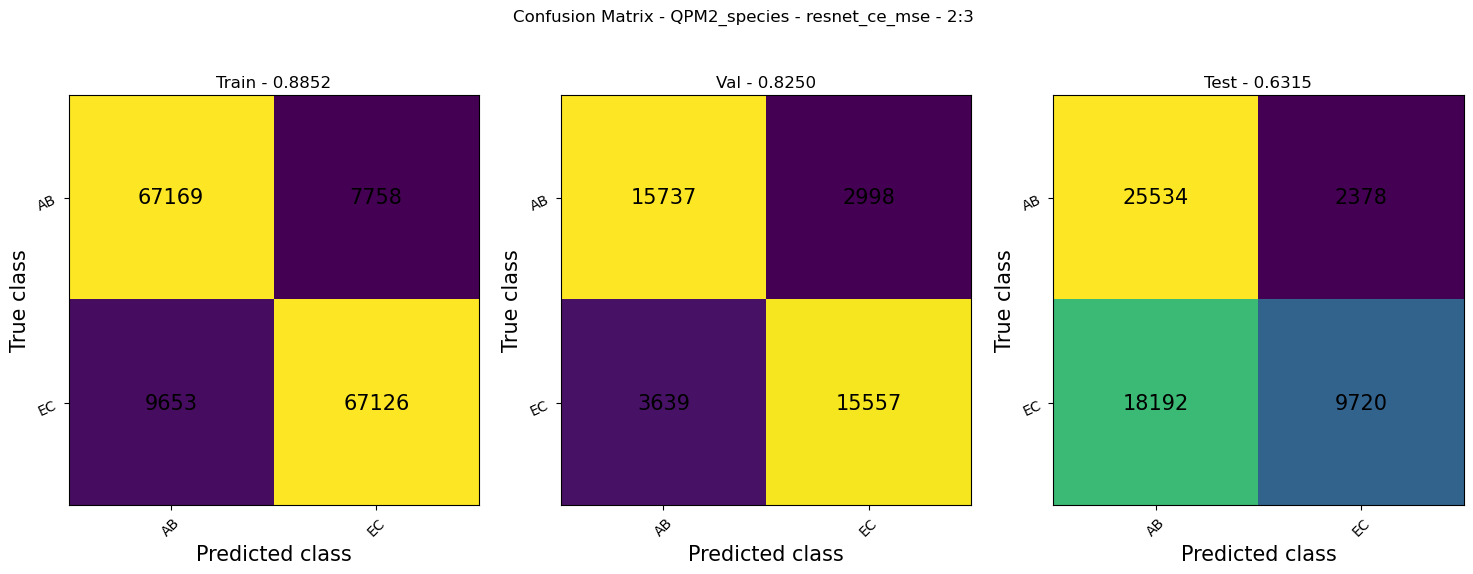

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(55824, 2) (41868, 2)
(55824, 2) (41868, 2)


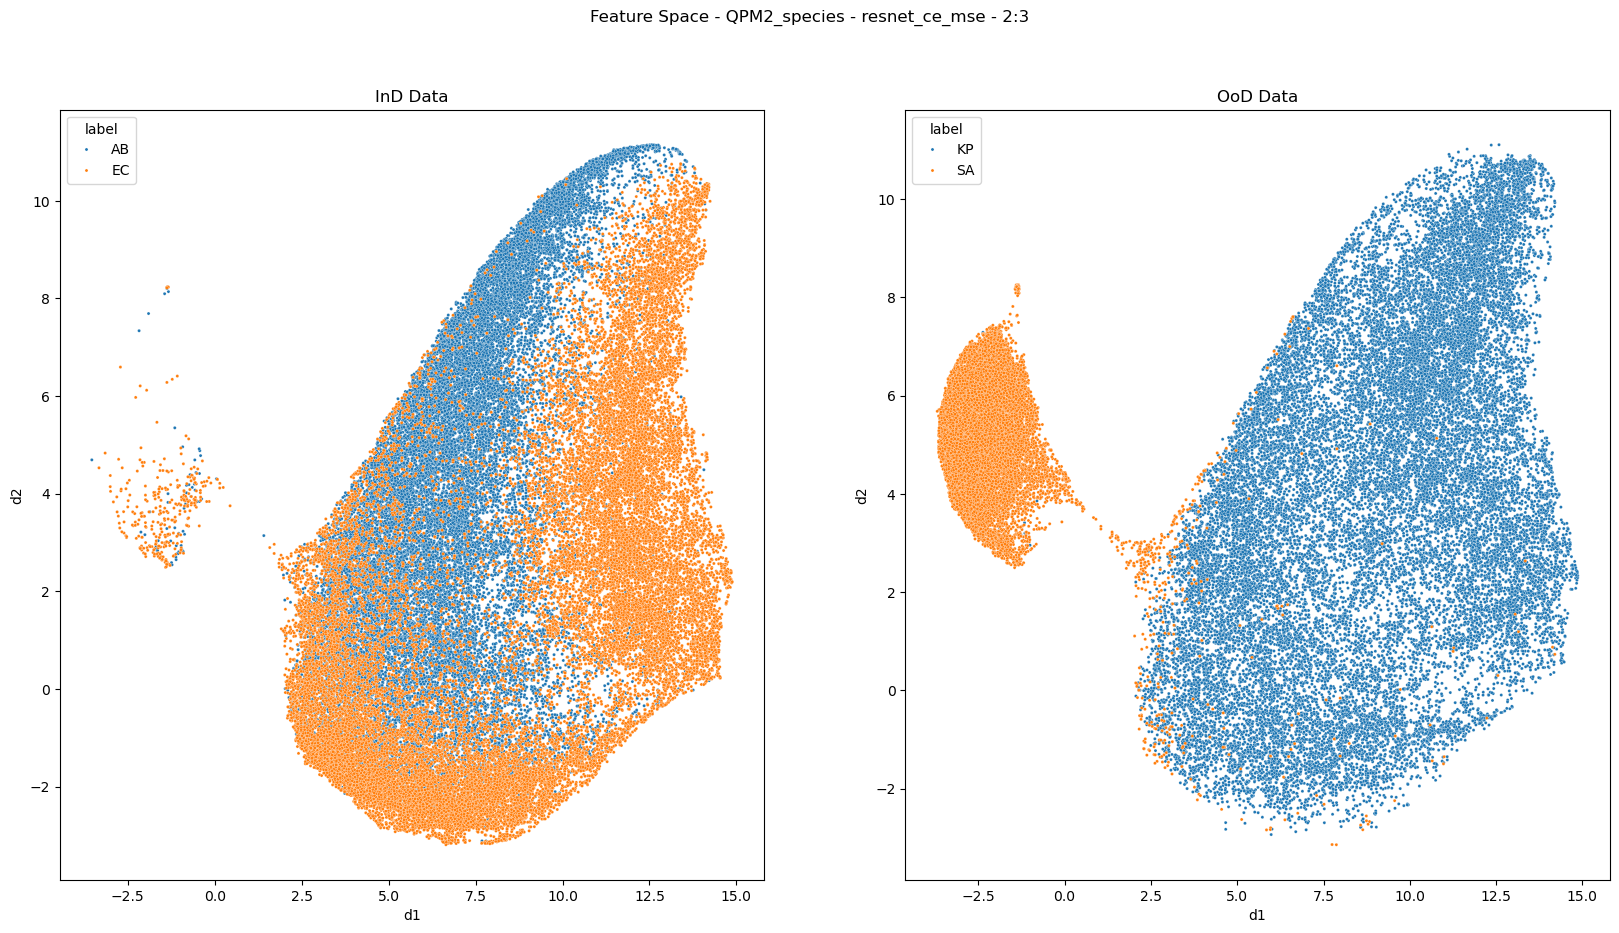

In [13]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

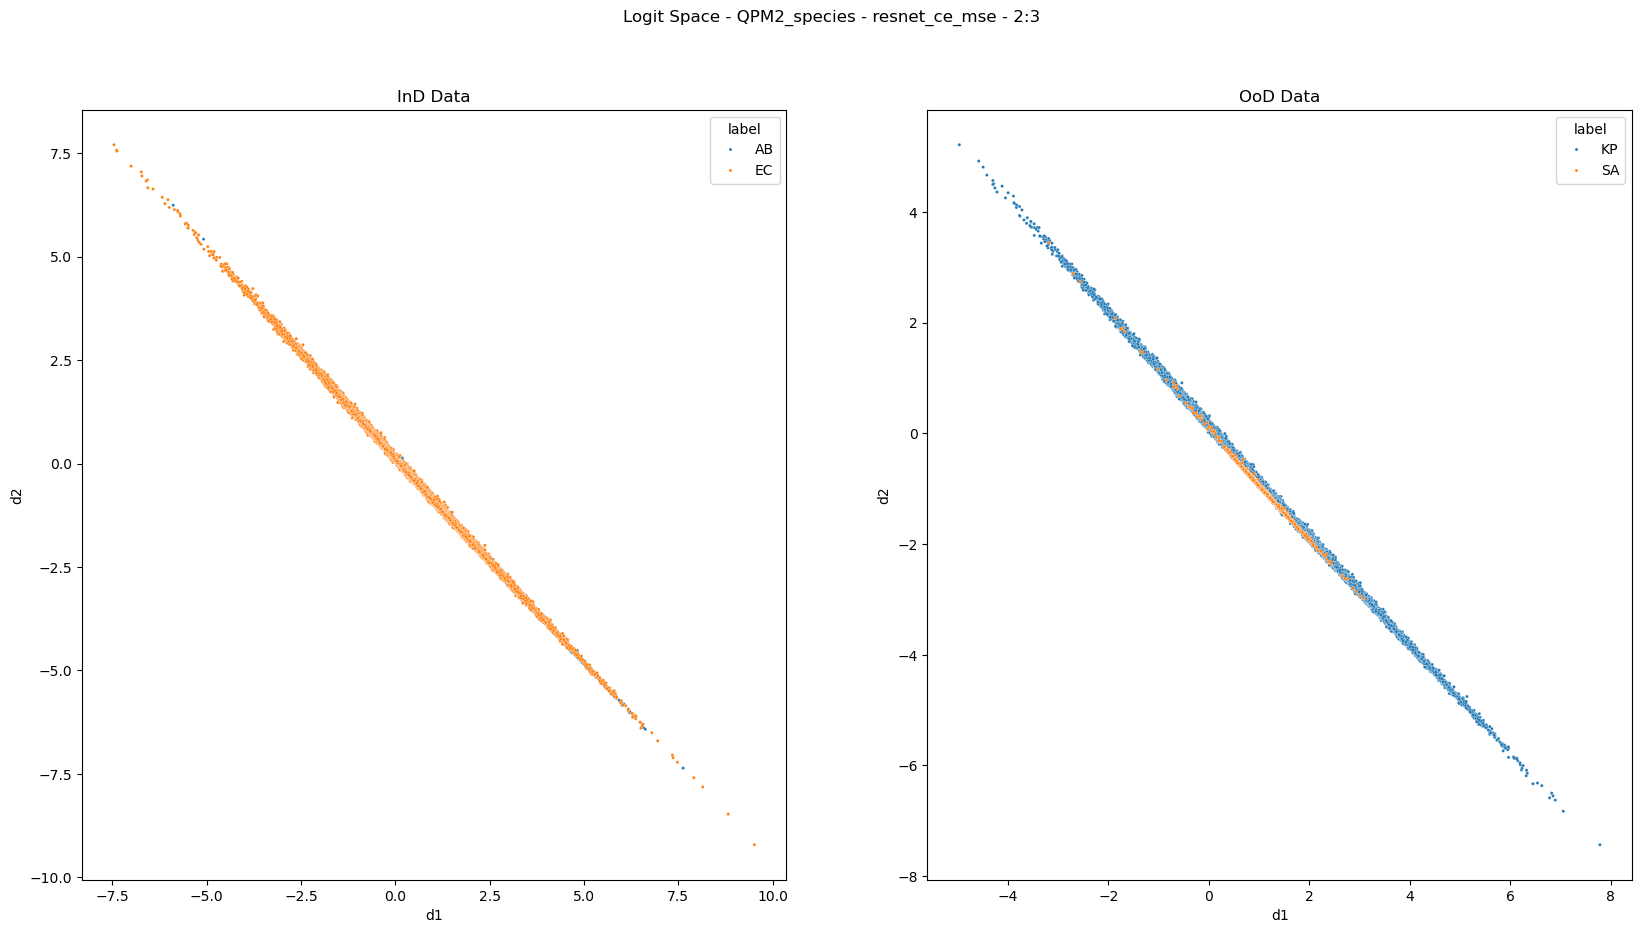

In [14]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

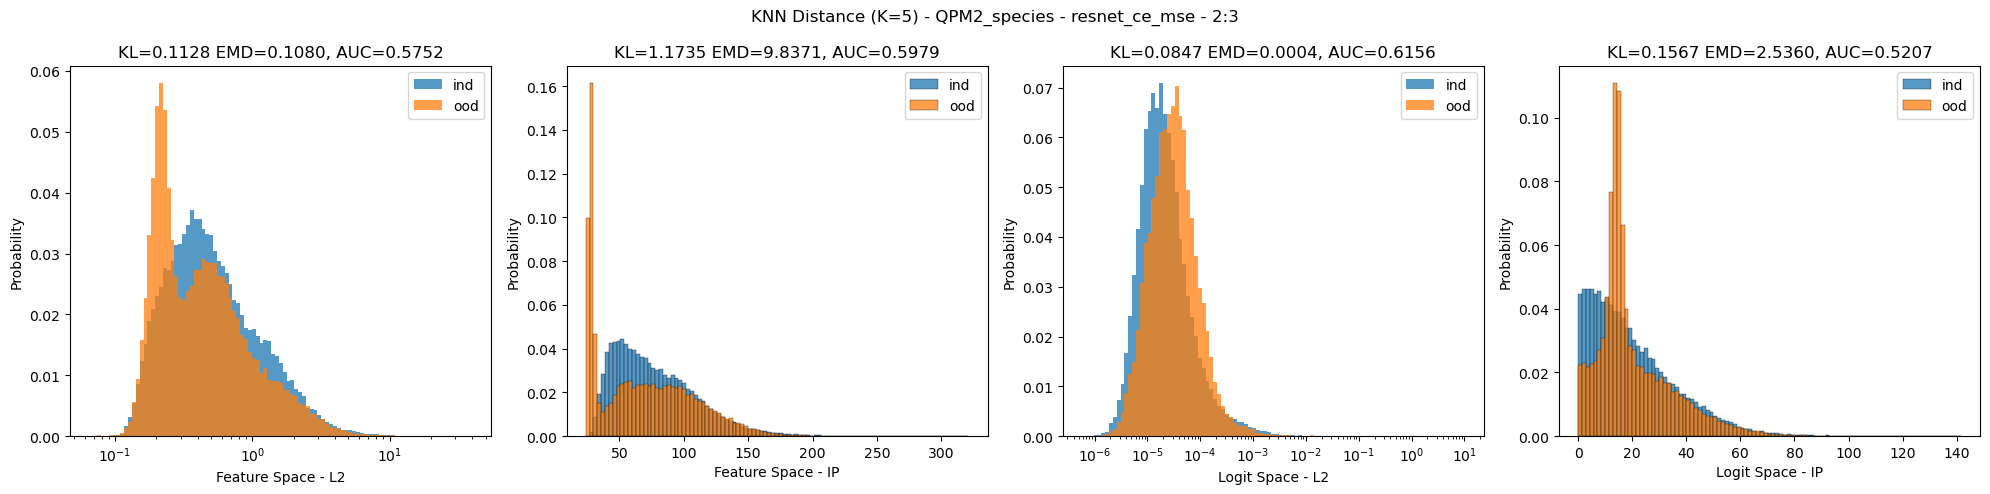

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

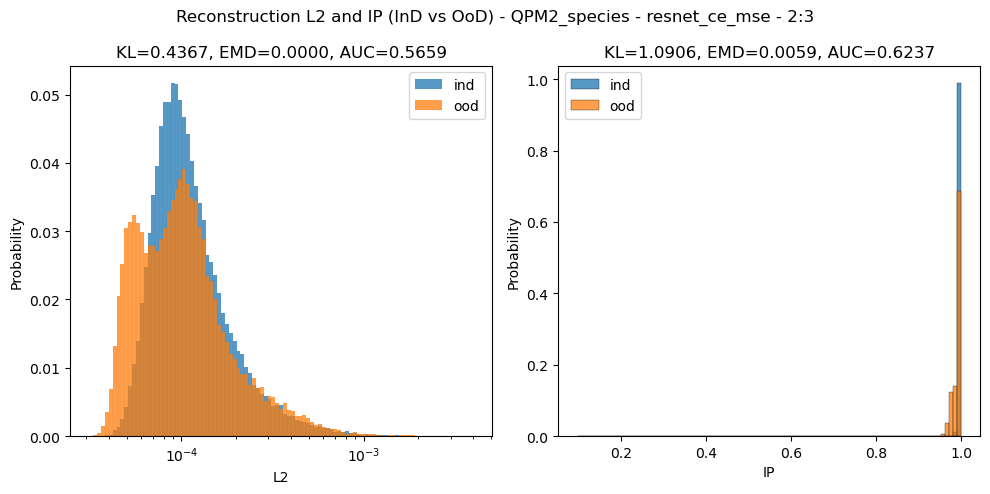

In [16]:
# plot reconstruction error of ind and ood data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_rcn.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_rcn.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

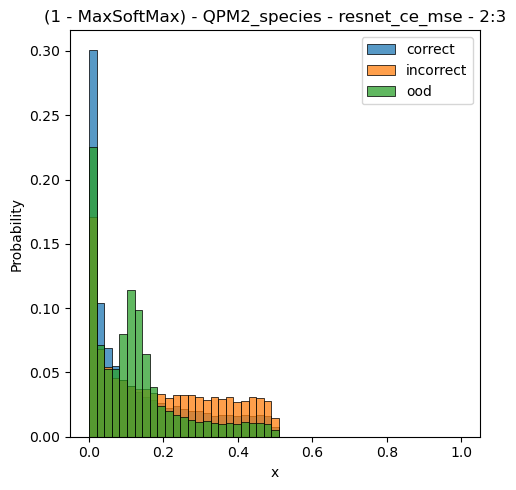

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [18]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)